In [21]:
import sys
sys.path.append('reflutils')
sys.path.append("C:/Users/hduva/CarbonLab/P-RSoXR/src/pypxr")
import reflutils as ru
import numpy as np

%matplotlib inline
from pypxr.structure import *
from pypxr.reflectivity import *
import matplotlib.pyplot as plt
import seaborn as sns
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective
from mcmc_analysis.utilities import compile_data_hdf5, load_prsoxr_hdf5, build_tensor, LogpExtra_rough
from mcmc_analysis.export_results import export_mcmc_summary
import pandas as pd
sns.set_style("darkgrid")

%matplotlib inline

# Bare Silicon

To start off with, we need a way to determine the thickness of silocon oxide present before deposition of the ZnPc. Thus we start by loading in the bare silicon data and fitting it to a model of just silicon and silicon oxide.

<Axes: xlabel='Q'>

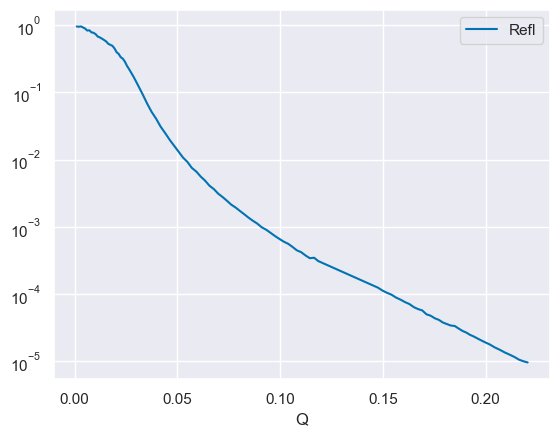

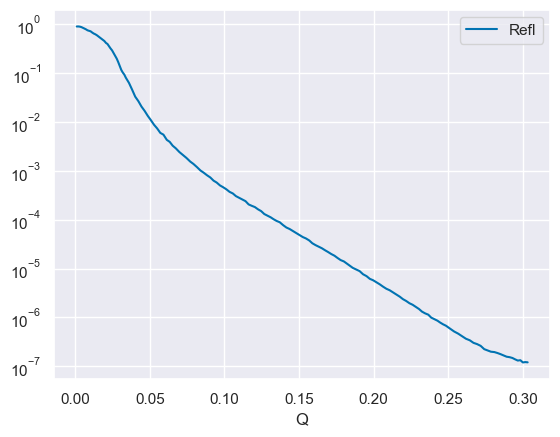

In [22]:
d_path = r"C:\Users\Harlan Heilman\Washington State University (email.wsu.edu)\Carbon Lab Research Group - Documents\Harlan Heilman\.refl\.csv"
d_path_l = r"C:\Users\hduva\Washington State University (email.wsu.edu)\Carbon Lab Research Group - Documents\Harlan Heilman\.refl\.csv"

bareSi_250_masked = pd.read_csv(d_path_l + r"\bareSi_250_masked.csv", index_col=0)
bareSi_320 = pd.read_csv(d_path_l + r"\bareSi_320.csv", index_col=0)

bareSi_250_masked.plot(x="Q", y="Refl", logy=True)
bareSi_320.plot(x="Q", y="Refl", logy=True)

## Converting to the right format

To start off, we need a function to transform the refl data frames into a form that can be used by the fitting function. This is done by the following function:

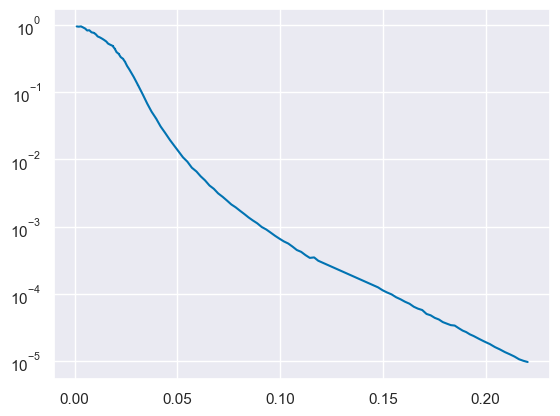

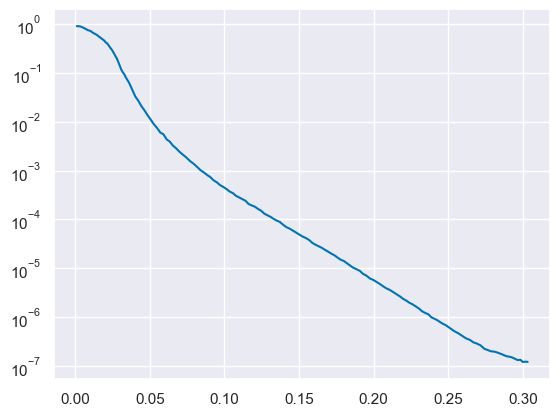

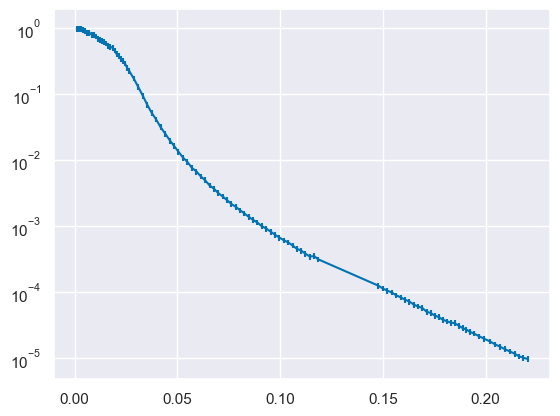

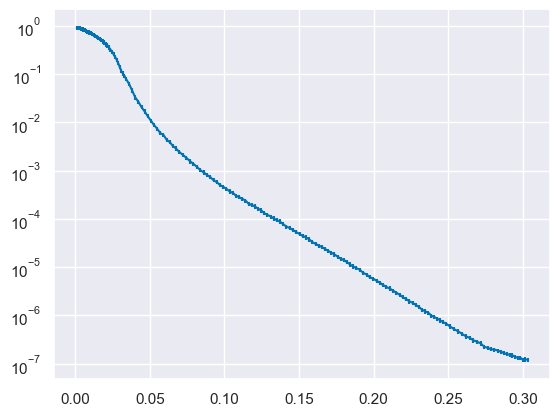

In [4]:
def to_refnx_dataset(refl):
    data = (refl.Q, refl.Refl, refl.Err)
    return ReflectDataset(data)


def to_scaled_refnx_dataset(refl):
    data = (refl.Q, refl.Refl, refl.Refl * 0.1)
    return ReflectDataset(data)


bareSi_250_masked_dataset = to_refnx_dataset(bareSi_250_masked)
bareSi_320_dataset = to_refnx_dataset(bareSi_320)

bareSi_250_masked_scaled_dataset = to_scaled_refnx_dataset(bareSi_250_masked)
bareSi_320_scaled_dataset = to_scaled_refnx_dataset(bareSi_320)

bareSi_250_masked_dataset.plot()
plt.yscale("log")
bareSi_320_dataset.plot()
plt.yscale("log")
bareSi_250_masked_scaled_dataset.plot()
plt.yscale("log")
bareSi_320_scaled_dataset.plot()
plt.yscale("log")

Now we need to construct the slab mosel using a series of slabs. This is done using the `PXR_MaterialSLD` and the `PXR_SLD`.

- `PXR_MaterialSLD` uses the periodic table package to determine the scattering length density of the material.
- `PXR_SLD` is a class that allows for user constructed materials

## Fitting the data

Here we have what should be a bare Si substrait, with a native oxide layer. But there is no reason we should assume this sample has no amorphous carbon, or other contaminants. Thus we will fit the data to a model of Si, SiO2, and a-C. Such a Structure looks something Like this 

Vacuum | a-C |  SiO2  |  Si  |

We know that there is a layer that is resonant at 320 eV who's thickness is on the order of ~1 nm (10 Angstroms). This can be seen in the data as a reflected fringe with an exceeding long period. 

So the general process we will take is as follows 

1. Construct two slab models
    1. 250 eV
    2. 320 eV
2. Do a basic MCMC fit of the 250 eV data and compare the results to the 320 eV data
    1. All layers must have a roughness < thickness of the layer
    2. All thicknesses should add to a total thickness of ~ 20 $\AA$
    3. The MCMC fit parameters should agree between the 250 eV data set and the 320 eV data set
3. Starting with the 250 eV parameters for thickness and roughness, do a MCMC fit of the 320 eV data set, and compare the results to the 250 eV data
    1. The same physical restrictions should still be in place, but the roughness of both SiO2 and Carbon can grow to be closer to the thickness of each layer.
    2. The MCMC fit parameters should agree between the 250 eV data set and the 320 eV data set
4. Using the multi energy fitting, with stronger constraints on the model, fit both energies simultaniously
    1. Want to use the allready fit thickness and roughness profiles
    2. Want to use the same physical restrictions as before
    3. Mostly want to allow the indices to varry at these energies.

## Constructing the models
Since the objective function continuously updates the model, if we want to uncouple the two energies, we want to create a unequely named model for each energy. We then use each energy to construct the `PXR_ReflectModel`.

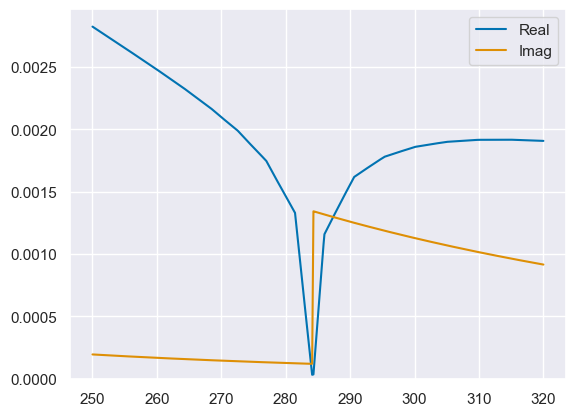

In [18]:
import periodictable
import periodictable.xsf

en = np.linspace(250, 320, 100000)

name = "C5H8O2"
formula = periodictable.formula(name)

_index = periodictable.xsf.index_of_refraction(formula, density=1.18, energy=en * 1e-3)
plt.plot(en, 1 - _index.real, label="Real")
plt.plot(en, -_index.imag, label="Imag")
plt.legend()
plt.ylim(bottom=0)
en2 = 250
en1 = 320
n_0 = 1 - _index.real[0]
n_1 = 1 - _index.real[-1]

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

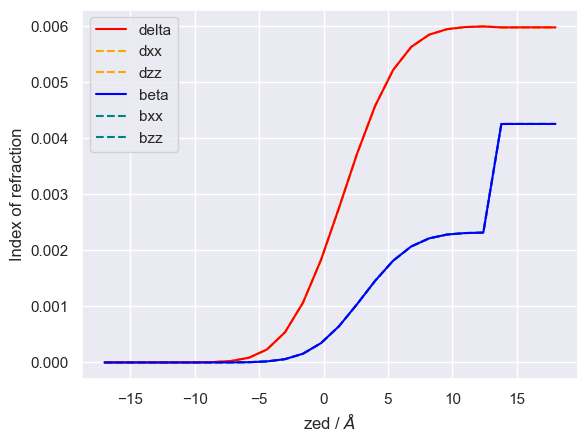

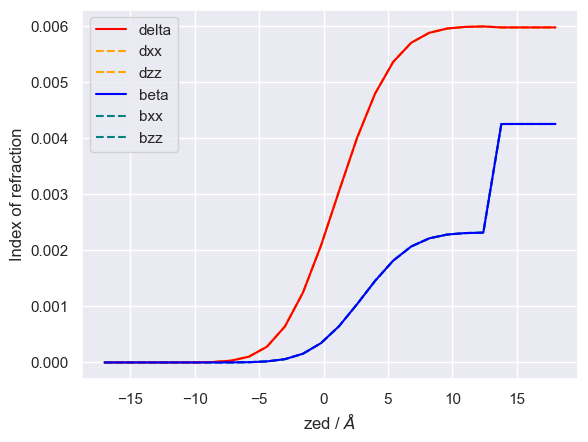

In [9]:
si = PXR_MaterialSLD("Si", 2.33, name="Si")  # substrate
vacuum = PXR_MaterialSLD("", 1, name="Vacuum")  # Superstrate

# 320 eV
sio21 = PXR_MaterialSLD("SiO2", 2.28, name="SiO21")  # surface oxide
carbon1 = PXR_SLD(n_1, symmetry="iso", name="Carbon1")  # surface carbon

# 250 eV
sio22 = PXR_MaterialSLD("SiO2", 2.28, name="SiO22")  # surface oxide
carbon2 = PXR_SLD(n_0, symmetry="iso", name="Carbon2")  # surface carbon


si_slab = si(0, 0)

sio2_slab_en1 = sio21(10, 3.07)
carbon_slab_en1 = carbon1(3, 3)

sio2_slab_en2 = sio22(10, 3.07)
carbon_slab_en2 = carbon2(3, 3)

structure1 = vacuum | carbon_slab_en1 | sio2_slab_en1 | si_slab
structure2 = vacuum | carbon_slab_en2 | sio2_slab_en2 | si_slab

structure1.plot()
structure2.plot()

## Setting Up the Objective Functions

Now, we want to construct the models such that there are two models, one for each energy. We then need to onstruct objective functions using each model, and the data that both uses the raw data, and one with an atrificially increased error.

As you can see, the current model is constructed using a compleate guess on thickness and roughness of the various parameters and poorly fits the data. So in the next step, we need to fit the 250 eV dataset and determine the goodness of that fit. 

## Choosing Parameters to Vary

To start out, we should look at the maximum range the parameters can be. Here we impose that the roughness tends to be less than the thickness and the total thickness of the layer is approximately 16 $\AA$.

In [15]:
model_1 = PXR_ReflectModel(structure1, energy=en1, pol="s", name="320 eV")
model_2 = PXR_ReflectModel(structure2, energy=en2, pol="s", name="250 eV")

si_slab.thick.setp(vary=False)
si_slab.rough.setp(
    vary=False, bounds=(1, 2)
)  # setting this to approximately .5 Angstroms

# 320 eV
sio2_slab_en1.thick.setp(vary=True, bounds=(0, 20))
sio2_slab_en1.rough.setp(vary=False, bounds=(1, 5))

carbon_slab_en1.thick.setp(vary=True, bounds=(0, 20))
carbon_slab_en1.rough.setp(vary=True, bounds=(0, 5))
carbon_slab_en1.sld.beta.setp(vary=True, bounds=(0, 0.01))
carbon_slab_en1.sld.delta.setp(vary=True, bounds=(0, 0.01))

# 250 eV
sio2_slab_en2.thick.setp(vary=True, bounds=(0, 20))
sio2_slab_en2.rough.setp(vary=False, bounds=(1, 5))

carbon_slab_en2.thick.setp(vary=True, bounds=(0, 20))
carbon_slab_en2.rough.setp(vary=True, bounds=(0, 5))
carbon_slab_en2.sld.beta.setp(vary=True, bounds=(0, 0.01))
carbon_slab_en2.sld.delta.setp(vary=True, bounds=(0, 0.01))

### Inequality Constraints

While these constraints are fine, we need to empose some physicality to the system. Our conditions are as follows:

1. The roughness of a layer should be less than the thickness of the layer
2. The total thickness of the layers should be less than 20 $\AA$
3. The total thickness of the layers should be greater than 10 $\AA$

So now we set this such that that there is a penalty for violating these conditions. For now we do this using a Non-linear constraint. 

Now that these nonlinear constraints are present for differential evolution, we can run the monte carlo sampling with similar such constraints. This means that we will need to add to the sampling a masking term to the probability distribution. To understand this, we should take a look under the hood of MCMC. 

## MCMC under the hood

MCMC is a method of sampling a probability distribution. This is done by starting at a random point in the distribution, and then randomly walking around the distribution. If the new point is more probable than the old point, then the new point is accepted. If the new point is less probable than the old point, then the new point is accepted with a probability equal to the ratio of the new point to the old point. Doing this with a single point is useless, so you should spawn several such "Walkers" into this distribution and let them all walk around looking then at the end of the walk, you can look at the distribution of points and see what the probability distribution looks like. 

In general, we want to approach MCMC from a Baysean approach, i.e. we must assume that the probability distribution is a product of the prior and the likelihood.

$$
    P(\theta | U) = \frac{P(U|\theta) P(\theta)}{P(U)}
$$
where we call $U$ the data, and $\theta$ the parameters. To break this down, we have the following terms

$$
    P(\theta | U) = \text{Posterior} \\
    P(U|\theta) = \text{Likelihood} \\
    P(\theta) = \text{Prior} \\
    P(U) = \text{Evidence} \\
$$

### LM vs MCMC
The posterior is the probability distribution of the parameters given the data. The likelihood is the probability of the data given the parameters. The prior is the probability of the parameters given no data, this is a key aspect of baysean statistics, as it allows us to incorporate prior knowledge into the model. The evidence is the probability of the data, this is a normalization constant that is not important for most physical applications allowing us to treat it as a normalization factor, i.e.

$$
    P(\theta | U) \propto P(U|\theta) P(\theta). \\
$$

Now, if we presuppose that all errors in the system are gaussian, and al parameters are linearly independent, then we can write the likelihood as a product of gaussians, and the prior as a uniform distribution. This is a very strong assumption, but it is a good starting point.

$$
    P(U | \theta) \propto P_i(\theta)\prod_i P_i(U_i - f_i(\theta))\\
$$

Once more, the product is just a normalization factor, so we can ignore it. This leaves us with the following expression

$$
    P(U | \theta) \propto \prod_i P_i(U_i - f_i(\theta))\\
$$

Now, explicitly, the likelyhood is a N-dimensional gaussian function meaning that we can write this out as 

$$
    P(U | \theta) \propto \prod_i \exp\left(-\frac{(U - f(\theta))^2}{2\sigma_i^2}\right).
$$  

The goal of any fitting is to determine the most likely set of parameters that give the so called truth. This is done by maximizing the posterior probability, and we have shown, that this is an exactly proportional task to maximizing the likelyhood. By convention, we optimize by minimiziging a "cost function", or "objective function"; to do this we take the negative log of the likelyhood providing us with a convex function to minimize, i.e., 

$$
    -\log(P(U | \theta)) = \sum_i \frac{(U - f(\theta))^2}{2\sigma_i^2} = \chi^2.
$$

This is the so called $\chi^2$ function, and is the basis of all least squares fitting, and the Levenberg-Marquardt algorithm. 

While this method works fine if we make the strong assumptions made above, it is easier to sample the posterior distribution directly though Monte-Carlo sampling. This is the basis for the MCMC technique. 

## Adding to the objective function

Notice that any prior distribution will be a function of the parameters, and can be used to kil certian regions of parameter space. If for example, the prior is a uniform distribution, then it will kill all regions of parameter space that are outside of the bounds of the prior. This is a very useful tool, as it allows us to kill off regions of parameter space that are non physical. 

Another way we can kill regions of parameter space is via adding terms to the likelyhood that set the likelyhood to zero if a condition is met. This is a non linear constraint that kills walkers if they end up in these nonphysical domains. 

Thus, we will add in a Thickness Roughness constraint that will return a probability of $-\infty$ if the roughness is greater than the thickness. This will kill off any walkers that end up in this region of parameter space. While this works in theory, in practice, we should simply add a large negetive number to the log prior. 

In [14]:
from refnx._lib.emcee.moves.de import *  # Differential Evolution MCMC move - typically used in these fits
import os

random_state = 1124

nwalkers = 1000

nsamples = 200

move = [(DEMove(sigma=1e-7), 0.95), (DEMove(sigma=1e-7, gamma0=1), 0.05)]

chain_name = "SaveChain.txt"

save_fitter = "fitter.pkl"

reflect_datasets = [bareSi_320_dataset, bareSi_250_masked_dataset]

obj_temp = Objective(
    model_1, bareSi_320_dataset, transform=Transform("logY"), name="obj_" + str(en)
)
# lpe = LogpExtra_rough(obj_temp)
# obj_temp.logp_extra = lpe

# Create the curvefitter
fitter = CurveFitter(obj_temp, nwalkers=nwalkers, moves=move)
fitter.initialise(pos="jitter")
chain = fitter.sample(
    nsamples, f=(os.path.join(d_path_l, chain_name)), random_state=random_state
)

ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance

Now, we fix the thickness and roughness of the carbon layer, and open up the roughness of silicon oxide as we look twards the 250 eV data set.

## Refinement using 250 eV

Now that we have a good idea of the parameters for the 320 eV data set, we can use this to better constrain the 250 eV data set and narrow down any parameters while still allowing for some room for improvements. 

In [127]:
sio2_slab_en1.thick.setp(vary=False)
sio2_slab_en1.rough.setp(vary=False)
carbon_slab_en1.thick.setp(vary=False)
carbon_slab_en1.rough.setp(vary=False)
print(obj_2.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:'Carbon2_diso' , value=0.003          , bounds=[0.0, 0.01]>
<Parameter:'Carbon2_biso' , value=0.005          , bounds=[0.0, 0.01]>


3.0862974043402076e+18: : 1it [00:00,  3.29it/s]
c:\ProgramData\anaconda3\envs\refl\Lib\site-packages\refnx\analysis\objective.py:770: LinAlgWarning: The following Parameters have no effect on Objective.residuals, please consider fixing them.
[Parameter(value=0.009560825124441761, name='Carbon2_diso', vary=True, bounds=Interval(lb=0.0, ub=0.01), constraint=None), Parameter(value=0.004766203025742716, name='Carbon2_biso', vary=True, bounds=Interval(lb=0.0, ub=0.01), constraint=None)]
  warnings.warn(


________________________________________________________________________________
Parameters:      None      
<Parameter:'Carbon2_diso' , value=0.00956083   +/- 0  , bounds=[0.0, 0.01]>
<Parameter:'Carbon2_biso' , value=0.0047662   +/- 0  , bounds=[0.0, 0.01]>


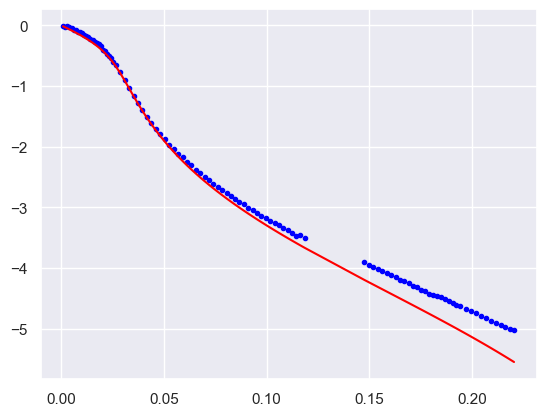

In [131]:
fitter2 = CurveFitter(obj_2)
fitter2.fit("differential_evolution")
obj_2.plot()
print(obj_2.varying_parameters())

In [132]:
print(obj_1_s.varying_parameters())
print(obj_2_s.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:'Carbon1_diso' , value=0.0044604 +/- 1.96e-07, bounds=[0.0, 0.01]>
<Parameter:'Carbon1_biso' , value=0.00518362 +/- 1.43e-07, bounds=[0.0, 0.01]>
________________________________________________________________________________
Parameters:      None      
<Parameter:'Carbon2_diso' , value=0.00956083   +/- 0  , bounds=[0.0, 0.01]>
<Parameter:'Carbon2_biso' , value=0.0047662   +/- 0  , bounds=[0.0, 0.01]>
